# Рубежный контроль №2

## Ишков Денис Олегович, ИУ5-24М, 2021г.

## Тема: Методы обработки текстов
## Решение задачи классификации текстов.
Необходимо решить задачу классификации текстов на основе любого выбранного Вами датасета (кроме примера, который рассматривался в лекции). Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного Вами датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

Необходимо сформировать два варианта векторизации признаков - на основе CountVectorizer и на основе TfidfVectorizer.

В качестве классификаторов необходимо использовать два классификатора по варианту для Вашей группы:

Группа: ИУ5-24М

Классификатор 1: KNeighborsClassifier

Классификатор 2: Complement Naive Bayes (CNB)

Для каждого метода необходимо оценить качество классификации. Сделайте вывод о том, какой вариант векторизации признаков в паре с каким классификатором показал лучшее качество.

## Датасет

Бинарная классификация текста

https://www.kaggle.com/blackmoon/russian-language-toxic-comments

In [2]:
# загрузка датасета
!pip install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/wedARfrtMn-Y-Q) -o labeled.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 4560k  100 4560k    0     0  1279k      0  0:00:03  0:00:03 --:--:-- 1921k


# Импорт нужных библиотек

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Анализ и обработка выбросов в данных

In [5]:
df = pd.read_csv("labeled.csv", sep=",")

df.describe()

,toxic
count,14412.000000
mean,0.334860
std,0.471958
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


<AxesSubplot:ylabel='Frequency'>

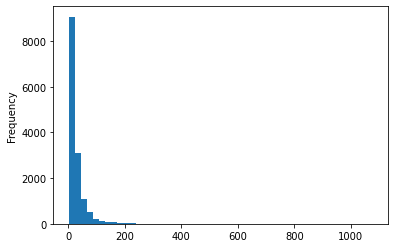

In [73]:
df.comment.str.split(' ').apply(len).plot(kind='hist', bins=50)

Как видно из гистограммы, количество слов сообщений в данных распределено по экспоненциальному закону. Уберём "хвост"

<AxesSubplot:ylabel='Frequency'>

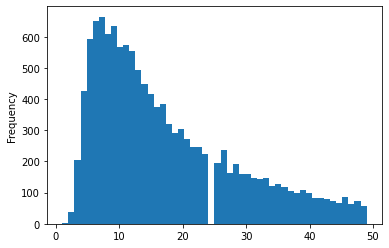

In [75]:
df = df[df.comment.str.split(' ').apply(len) < 50].copy()
df.comment.str.split(' ').apply(len).plot(kind='hist', bins=50)

In [76]:
df["toxic"] = df["toxic"].apply(int)
df["toxic"].value_counts()

0    8102
1    4419
Name: toxic, dtype: int64

### Разделим данные на обучающую и тестовую выборки

In [82]:
train_df, test_df = train_test_split(df, test_size=500, stratify=df.toxic)

In [83]:
test_df["toxic"].value_counts(), train_df["toxic"].value_counts()

(0    324
 1    176
 Name: toxic, dtype: int64,
 0    7778
 1    4243
 Name: toxic, dtype: int64)

# Предобработка текста

In [84]:
sentence_example = df.iloc[-1]["comment"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [85]:
print(f"Исходный текст: {sentence_example}")
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-----------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}")
print("-----------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------")

Исходный текст: До сих пор пересматриваю его видео. Орамбо кстати на своем канале пилит похожий контент, но качеством похуже, там же и Шуран не редко светится, храню хрупкую надежду что когда-то он вернется, такая годнота ведь.

-----------------
Токены: ['До', 'сих', 'пор', 'пересматриваю', 'его', 'видео', '.', 'Орамбо', 'кстати', 'на', 'своем', 'канале', 'пилит', 'похожий', 'контент', ',', 'но', 'качеством', 'похуже', ',', 'там', 'же', 'и', 'Шуран', 'не', 'редко', 'светится', ',', 'храню', 'хрупкую', 'надежду', 'что', 'когда-то', 'он', 'вернется', ',', 'такая', 'годнота', 'ведь', '.']
-----------------
Токены без пунктуации: ['До', 'сих', 'пор', 'пересматриваю', 'его', 'видео', 'Орамбо', 'кстати', 'на', 'своем', 'канале', 'пилит', 'похожий', 'контент', 'но', 'качеством', 'похуже', 'там', 'же', 'и', 'Шуран', 'не', 'редко', 'светится', 'храню', 'хрупкую', 'надежду', 'что', 'когда-то', 'он', 'вернется', 'такая', 'годнота', 'ведь']
-----------------
Токены без пунктуации и стоп слов: ['Д

In [86]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

tokenize_sentence(sentence_example)

['до',
 'сих',
 'пор',
 'пересматрива',
 'виде',
 'орамб',
 'кстат',
 'сво',
 'канал',
 'пил',
 'похож',
 'контент',
 'качеств',
 'похуж',
 'шура',
 'редк',
 'свет',
 'хран',
 'хрупк',
 'надежд',
 'когда-т',
 'вернет',
 'так',
 'годнот']

## Классификатор 1: Complement Naive Bayes

### CountVectorizer

{'alpha': 0.44499999999999995, 'norm': False}
              precision    recall  f1-score   support

           0     0.8899    0.9228    0.9061       324
           1     0.8476    0.7898    0.8176       176

    accuracy                         0.8760       500
   macro avg     0.8687    0.8563    0.8619       500
weighted avg     0.8750    0.8760    0.8749       500



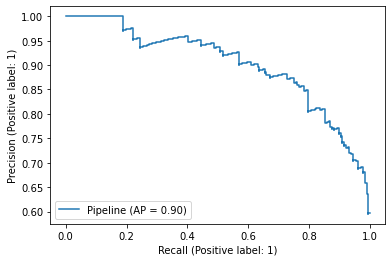

In [140]:
grid_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        ComplementNB(alpha=1.0, norm=False),
        param_grid={'alpha': [0.35+5e-3*i for i in range(20)],
                    'norm': [True, False]},
        cv=5,
        verbose=0,
        scoring='roc_auc',
        )
    )
])

grid_pipeline.fit(train_df["comment"], train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", ComplementNB(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(train_df["comment"], train_df["toxic"])
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"],
                                                              probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(test_df["comment"]),
                            digits=4))

### TfidfVectorizer

{'alpha': 0.41, 'norm': False}
              precision    recall  f1-score   support

           0     0.8896    0.9198    0.9044       324
           1     0.8424    0.7898    0.8152       176

    accuracy                         0.8740       500
   macro avg     0.8660    0.8548    0.8598       500
weighted avg     0.8730    0.8740    0.8730       500



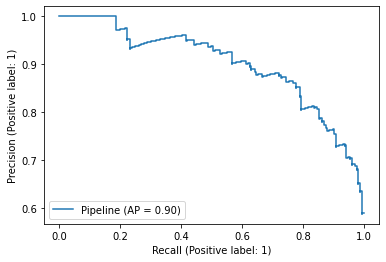

In [141]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        ComplementNB(alpha=1.0, norm=False),
        param_grid={'alpha': [0.35+5e-3*i for i in range(20)],
                    'norm': [True, False]},
        cv=5,
        verbose=0,
        scoring='roc_auc',
        )
    )
])

grid_pipeline.fit(train_df["comment"], train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", ComplementNB(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(train_df["comment"], train_df["toxic"])
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"],
                                                              probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(test_df["comment"]),
                            digits=4))

## Классификатор 2: KNearestNeighbors

### CountVectorizer

Fitting 5 folds for each of 132 candidates, totalling 660 fits
{'metric': 'cosine', 'n_neighbors': 62, 'weights': 'distance'}
              precision    recall  f1-score   support

           0     0.7778    0.9722    0.8642       324
           1     0.9053    0.4886    0.6347       176

    accuracy                         0.8020       500
   macro avg     0.8415    0.7304    0.7494       500
weighted avg     0.8227    0.8020    0.7834       500



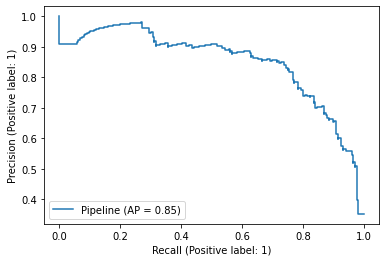

In [142]:
grid_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        KNeighborsClassifier(),
        param_grid={'n_neighbors': [i for i in range(31, 64, 1)],
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'cosine',]},
        cv=5,
        verbose=1,
        scoring='roc_auc', #'f1'
        )
    )
])

grid_pipeline.fit(train_df["comment"], train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", KNeighborsClassifier(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(train_df["comment"], train_df["toxic"])
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"],
                                                              probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(test_df["comment"]),
                            digits=4))

### Какие параметры лучшие?

In [143]:
cols = ['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']
pd.DataFrame(grid_pipeline['model'].cv_results_).sort_values(by='rank_test_score').loc[:, cols].head(10)

,param_metric,param_n_neighbors,param_weights,mean_test_score
129,cosine,62,distance,0.865295
131,cosine,63,distance,0.865283
127,cosine,61,distance,0.865031
130,cosine,63,uniform,0.865012
128,cosine,62,uniform,0.865002
125,cosine,60,distance,0.864925
123,cosine,59,distance,0.864745
126,cosine,61,uniform,0.864692
124,cosine,60,uniform,0.864582
119,cosine,57,distance,0.864509


### TFidfVectorizer

Fitting 5 folds for each of 68 candidates, totalling 340 fits
{'metric': 'cosine', 'n_neighbors': 45, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0     0.7834    0.9599    0.8627       324
           1     0.8738    0.5114    0.6452       176

    accuracy                         0.8020       500
   macro avg     0.8286    0.7356    0.7539       500
weighted avg     0.8152    0.8020    0.7861       500



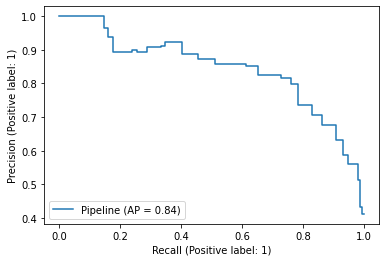

In [144]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        KNeighborsClassifier(),
        param_grid={'n_neighbors': [i for i in range(31, 64, 2)],
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'cosine',]},
        cv=5,
        verbose=1,
        scoring='roc_auc', #'f1'
        )
    )
])

grid_pipeline.fit(train_df["comment"], train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", KNeighborsClassifier(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(train_df["comment"], train_df["toxic"])
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"],
                                                              probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(test_df["comment"]),
                            digits=4))

### Какие параметры лучшие?

In [145]:
cols = ['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']
pd.DataFrame(grid_pipeline['model'].cv_results_).sort_values(by='rank_test_score').loc[:, cols].head(10)

,param_metric,param_n_neighbors,param_weights,mean_test_score
48,cosine,45,uniform,0.917287
50,cosine,47,uniform,0.917125
54,cosine,51,uniform,0.917124
46,cosine,43,uniform,0.916920
44,cosine,41,uniform,0.916891
42,cosine,39,uniform,0.916859
56,cosine,53,uniform,0.916817
58,cosine,55,uniform,0.916817
60,cosine,57,uniform,0.916806
52,cosine,49,uniform,0.916661


# Выводы

|                 | ComplementNB | KNN Classifier |
|-----------------|--------------|----------------|
| CountVectorizer | 0.8749       | 0.7834         |
| TfIdfVectorizer | 0.8730       | 0.7861         |

Лучше всего по f1-мере показала себя связка CountVectorizer + ComplementNB.